# College Scorecard Data Analysis
## Modeling Income-Share Agreements from College Outcomes Data (US Focus)
In this notebook, we are trying to model whether a school's parameters affect the outcomes of their graduates. This is essential for creating profitable income-share agreement contracts where students' financing repayments is based on their future income.

### Kaggle Kernel Notes
We used a Kaggle Kernel given the size of our dataset and the efficiency of cloud compute and cloud storage offered by the kernel.
Below are some essential notes about this Python 3 Jupyter Notebook Environment:
- It is defined by the `kaggle/python` Docker image: https://github.com/kaggle/docker-python
- Input data files are available in the read-only `../input/` directory
- You can write up to 20GB to the current directory `/kaggle/working/` that gets preserved as output when creating version 
- You can also write temporary files to `/kaggle/temp/`, but they won't be saved outside of the current session

In [28]:
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # advanced visualisations
import matplotlib.pyplot as plt # data visualisation

In [29]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_columns', 5000) #High dimensionality data involved
warnings.simplefilter("once") #Only show warnings once
%matplotlib inline

/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecardDataDictionary.xlsx
/kaggle/input/college-scorecard-aggregated-dataset/InstitutionDataDocumentation.pdf
/kaggle/input/college-scorecard-aggregated-dataset/FieldOfStudyDataDocumentation.pdf
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/Most-Recent-Cohorts-Institution.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED1997_98_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/FieldOfStudyData1718_1819_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2006_07_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2011_12_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2002_03_PP.csv
/kaggle/input/college-scorecard-aggregated-da

## Exploratory Data Analysis

### Data Importation & Consolidation

In [31]:
# Define the file names for the year we want to import data for
years = [2001,2002,2003,2004,2005,2006,2007,2008,2009,2010] # Years of data we are interested in
fnames = list()

for year in years:
    fname = "/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data//MERGED" + str(year) + "_" + str(year+1)[2:] + "_PP.csv" #Based on format of file names
    fnames.append(fname)
print(len(fnames))

10


In [ ]:
## Import first dataset – the base year dataset
data = pd.read_csv(str(fnames[0]), low_memory=False)
data["DATAYEAR"] = years[0]
dshapes = [data.shape]

## Import other datasets and concat into the base dataset
for i in range(1,len(fnames)):
    try:
        df = pd.read_csv(str(fnames[i]), low_memory=False)
        df["DATAYEAR"] = years[i]
        dshapes.append(df.shape) # Track the shape of the added data
        data = pd.concat([data, df], ignore_index=True)
    except:
        print(f"File {fnames[i]} not available")

## PrivacySuppressed has been used as an alternative to None in Object Columns    
data = data.map(lambda x: None if x == "PrivacySuppressed" else x, na_action='ignore')

print(data.shape, dshapes)
data.head(10)

(69360, 3233) [(6725, 3233), (6652, 3233), (6673, 3233), (6747, 3233), (6899, 3233), (6951, 3233), (6971, 3233), (7055, 3233), (7217, 3233), (7470, 3233)]


UNITID     OPEID  OPEID6                               INSTNM  \
0  100636  01230800   12308   Community College of the Air Force   
1  100654  00100200    1002             Alabama A & M University   
2  100663  00105200    1052  University of Alabama at Birmingham   
3  100690  02503400   25034                   Amridge University   
4  100706  00105500    1055  University of Alabama in Huntsville   
5  100724  00100500    1005             Alabama State University   
6  100751  00105100    1051            The University of Alabama   
7  100760  00100700    1007    Central Alabama Community College   
8  100812  00100800    1008              Athens State University   
9  100830  00831000    8310      Auburn University at Montgomery   

             CITY STABBR         ZIP  ACCREDAGENCY  INSTURL  NPCURL  SCH_DEG  \
0      Montgomery     AL  36114-3011           NaN      NaN     NaN      NaN   
1          Normal     AL       35762           NaN      NaN     NaN      3.0   
2      Birmingham     AL  35294-0110           NaN      NaN     NaN      3.0   
3      Montgomery     AL  36117-3553           NaN      NaN     NaN      3.0   
4      Huntsville     AL       35899           NaN      NaN     NaN      3.0   
5      Montgomery     AL  36104-0271           NaN      NaN     NaN      3.0   
6      Tuscaloosa     AL  35487-0100           NaN      NaN     NaN      3.0   
7  Alexander City     AL       35010           NaN      NaN     NaN      2.0   
8          Athens     AL       35611           NaN      NaN     NaN      3.0   
9      Montgomery     AL  36117-3596           NaN      NaN     NaN      3.0   

   HCM2  MAIN  NUMBRANCH  PREDDEG  HIGHDEG  CONTROL  ST_FIPS  REGION  LOCALE  \
0   NaN     1          1        2        2      1.0        1       0     NaN   
1   NaN     1          1        3        4      1.0        1       5     NaN   
2   NaN     1          1        3        4      1.0        1       5     NaN   
3   NaN     1          1        3        4      2.0        1       5     NaN   
4   NaN     1          1        3        4      1.0        1       5     NaN   
5   NaN     1          1        3        4      1.0        1       5     NaN   
6   NaN     1          1        3        4      1.0        1       5     NaN   
7   NaN     1          1        2        2      1.0        1       5     NaN   
8   NaN     1          1        3        3      1.0        1       5     NaN   
9   NaN     1          1        3        4      1.0        1       5     NaN   

   LOCALE2  LATITUDE  LONGITUDE  CCBASIC  CCUGPROF  CCSIZSET  HBCU  PBI  \
0      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
1      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
2      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
3      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
4      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
5      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
6      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
7      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
8      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
9      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   

   ANNHI  TRIBAL  AANAPII  HSI  NANTI  MENONLY  WOMENONLY  RELAFFIL  ADM_RATE  \
0    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
1    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.7505   
2    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.9098   
3    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
4    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.8381   
5    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
6    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.7948   
7    NaN     NaN  

In [59]:
#PrivacySuppressed has been used as an alternative to None in Object Columns
data = data.map(lambda x: None if x == "PrivacySuppressed" else x, na_action='ignore')

#Filter data to only include data where our target variable is not not null
data.dropna(subset=['MN_EARN_WNE_P6'], inplace=True) ## Target: Mean Earning after 6 years

print(data.shape)
print(data.DATAYEAR.unique()) ## Years with our Target Variable not Null

(22122, 3233)


## Handling Missing Values

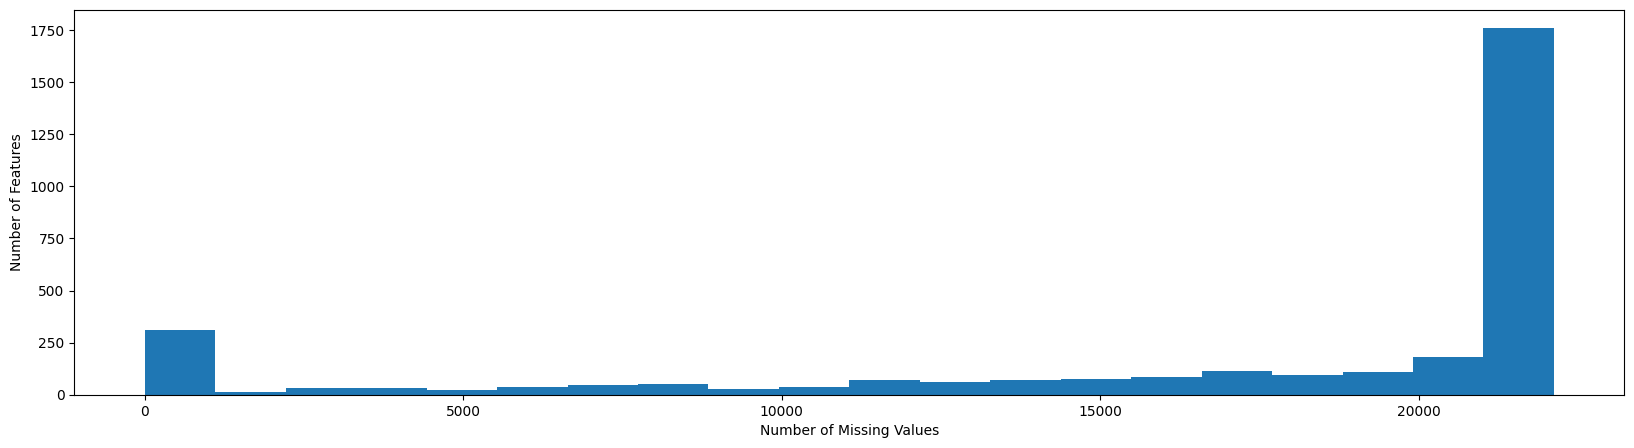

In [61]:
missing_values = data.isnull().sum(axis=0) # Identify all null values in the data
plt.figure(figsize=(20,5))
plt.hist(missing_values,bins=20,label=True)
plt.ylabel("Number of Features")
plt.xlabel("Number of Missing Values")
plt.show()

In [62]:
to_drop = list()
threshold = 0.5 * data.shape[0] #1738 seems to be the number from 0.2 to 0.4
for column in list(data.columns):
    if data[column].isnull().sum() > threshold:
        to_drop.append(column)
        
print(f"Drop {len(to_drop)/data.shape[1]*100}% of the columns")

Drop 81.07021342406433% of the columns


In [ ]:
data = data.drop(to_drop,axis=1) ## Drop columns with extreme missingness
data = data.drop_duplicates() ## Drop duplicate rows
print(data.shape)
data.head()

(22122, 612)


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,ST_FIPS,REGION,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,CIP01CERT1,CIP01CERT2,CIP01ASSOC,CIP01CERT4,CIP01BACHL,CIP03CERT1,CIP03CERT2,CIP03ASSOC,CIP03CERT4,CIP03BACHL,CIP04CERT1,CIP04CERT2,CIP04ASSOC,CIP04CERT4,CIP04BACHL,CIP05CERT1,CIP05CERT2,CIP05ASSOC,CIP05CERT4,CIP05BACHL,CIP09CERT1,CIP09CERT2,CIP09ASSOC,CIP09CERT4,CIP09BACHL,CIP10CERT1,CIP10CERT2,CIP10ASSOC,CIP10CERT4,CIP10BACHL,CIP11CERT1,CIP11CERT2,CIP11ASSOC,CIP11CERT4,CIP11BACHL,CIP12CERT1,CIP12CERT2,CIP12ASSOC,CIP12CERT4,CIP12BACHL,CIP13CERT1,CIP13CERT2,CIP13ASSOC,CIP13CERT4,CIP13BACHL,CIP14CERT1,CIP14CERT2,CIP14ASSOC,CIP14CERT4,CIP14BACHL,CIP15CERT1,CIP15CERT2,CIP15ASSOC,CIP15CERT4,CIP15BACHL,CIP16CERT1,CIP16CERT2,CIP16ASSOC,CIP16CERT4,CIP16BACHL,CIP19CERT1,CIP19CERT2,CIP19ASSOC,CIP19CERT4,CIP19BACHL,CIP22CERT1,CIP22CERT2,CIP22ASSOC,CIP22CERT4,CIP22BACHL,CIP23CERT1,CIP23CERT2,CIP23ASSOC,CIP23CERT4,CIP23BACHL,CIP24CERT1,CIP24CERT2,CIP24ASSOC,CIP24CERT4,CIP24BACHL,CIP25CERT1,CIP25CERT2,CIP25ASSOC,CIP25CERT4,CIP25BACHL,CIP26CERT1,CIP26CERT2,CIP26ASSOC,CIP26CERT4,CIP26BACHL,CIP27CERT1,CIP27CERT2,CIP27ASSOC,CIP27CERT4,CIP27BACHL,CIP29CERT1,CIP29CERT2,CIP29ASSOC,CIP29CERT4,CIP29BACHL,CIP30CERT1,CIP30CERT2,CIP30ASSOC,CIP30CERT4,CIP30BACHL,CIP31CERT1,CIP31CERT2,CIP31ASSOC,CIP31CERT4,CIP31BACHL,CIP38CERT1,CIP38CERT2,CIP38ASSOC,CIP38CERT4,CIP38BACHL,CIP39CERT1,CIP39CERT2,CIP39ASSOC,CIP39CERT4,CIP39BACHL,CIP40CERT1,CIP40CERT2,CIP40ASSOC,CIP40CERT4,CIP40BACHL,CIP41CERT1,CIP41CERT2,CIP41ASSOC,CIP41CERT4,CIP41BACHL,CIP42CERT1,CIP42CERT2,CIP42ASSOC,CIP42CERT4,CIP42BACHL,CIP43CERT1,CIP43CERT2,CIP43ASSOC,CIP43CERT4,CIP43BACHL,CIP44CERT1,CIP44CERT2,CIP44ASSOC,CIP44CERT4,CIP44BACHL,CIP45CERT1,CIP45CERT2,CIP45ASSOC,CIP45CERT4,CIP45BACHL,CIP46CERT1,CIP46CERT2,CIP46ASSOC,CIP46CERT4,CIP46BACHL,CIP47CERT1,CIP47CERT2,CIP47ASSOC,CIP47CERT4,CIP47BACHL,CIP48CERT1,CIP48CERT2,CIP48ASSOC,CIP48CERT4,CIP48BACHL,CIP49CERT1,CIP49CERT2,CIP49ASSOC,CIP49CERT4,CIP49BACHL,CIP50CERT1,CIP50CERT2,CIP50ASSOC,CIP50CERT4,CIP50BACHL,CIP51CERT1,CIP51CERT2,CIP51ASSOC,CIP51CERT4,CIP51BACHL,CIP52CERT1,CIP52CERT2,CIP52ASSOC,CIP52CERT4,CIP52BACHL,CIP54CERT1,CIP54CERT2,CIP54ASSOC,CIP54CERT4,CIP54BACHL,UGDS,UGDS_NRA,UGDS_UNKN,UGDS_WHITENH,UGDS_BLACKNH,UGDS_API,UGDS_AIANOLD,UGDS_HISPOLD,PPTUG_EF,TUITIONFEE_IN,TUITIONFEE_OUT,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,C150_L4,D150_L4,UG25ABV,CDR2,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,ENRL_ORIG_YR2_RT,ENRL_4YR_TRANS_YR2_RT,ENRL_2YR_TRANS_YR2_RT,UNKN_ORIG_YR2_RT,LO_INC_COMP_ORIG_YR2_RT,LO_INC_WDRAW_ORIG_YR2_RT,LO_INC_ENRL_ORIG_YR2_RT,DEP_COMP_ORIG_YR2_RT,DEP_WDRAW_ORIG_YR2_RT,DEP_ENRL_ORIG_YR2_RT,IND_COMP_ORIG_YR2_RT,IND_WDRAW_ORIG_YR2_RT,IND_ENRL_ORIG_YR2_RT,FEMALE_COMP_ORIG_YR2_RT,FEMALE_WDRAW_ORIG_YR2_RT,FEMALE_ENRL_ORIG_YR2_RT,FEMALE_UNKN_ORIG_YR2_RT,MALE_COMP_ORIG_YR2_RT,MALE_WDRAW_ORIG_YR2_RT,MALE_ENRL_ORIG_YR2_RT,MALE_UNKN_ORIG_YR2_RT,PELL_COMP_ORIG_YR2_RT,PELL_WDRAW_ORIG_YR2_RT,PELL_ENRL_ORIG_YR2_RT,NOPELL_COMP_ORIG_YR2_RT,NOPELL_WDRAW_ORIG_YR2_RT,NOPELL_ENRL_ORIG_YR2_RT,FIRSTGEN_COMP_ORIG_YR2_RT,FIRSTGEN_WDRAW_ORIG_YR2_RT,FIRSTGEN_ENRL_ORIG_YR2_RT,FIRSTGEN_ENRL_4YR_TRANS_YR2_RT,FIRSTGEN_UNKN_ORIG_YR2_RT,NOT1STGEN_COMP_ORIG_YR2_RT,NOT1STGEN_WDRAW_ORIG_YR2_RT,NOT1STGEN_ENRL_ORIG_YR2_RT,NOT1STGEN_ENRL_4YR_TRANS_YR2_RT,NOT1STGEN_UNKN_ORIG_YR2_RT,COMP_ORIG_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,ENRL_ORIG_YR3_RT,ENRL_4YR_TRANS_YR3_RT,UNKN_ORIG_YR3_RT,LO_INC_COMP_ORIG_YR3_RT,LO_INC_WDRAW_ORIG_YR3_RT,DEP_COMP_ORIG_YR3_RT,DEP_WDRAW_ORIG_YR3_RT,IND_COMP_ORIG_YR3_RT,IND_WDRAW_ORIG_YR3_RT,FEMALE_COMP_ORIG_YR3_RT,FEMALE_WDRAW_ORIG_YR3_RT,FEMALE_UNKN_ORIG_YR3_RT,MALE_COMP_ORIG_YR3_RT,MALE_WDRAW_ORIG_YR3_RT

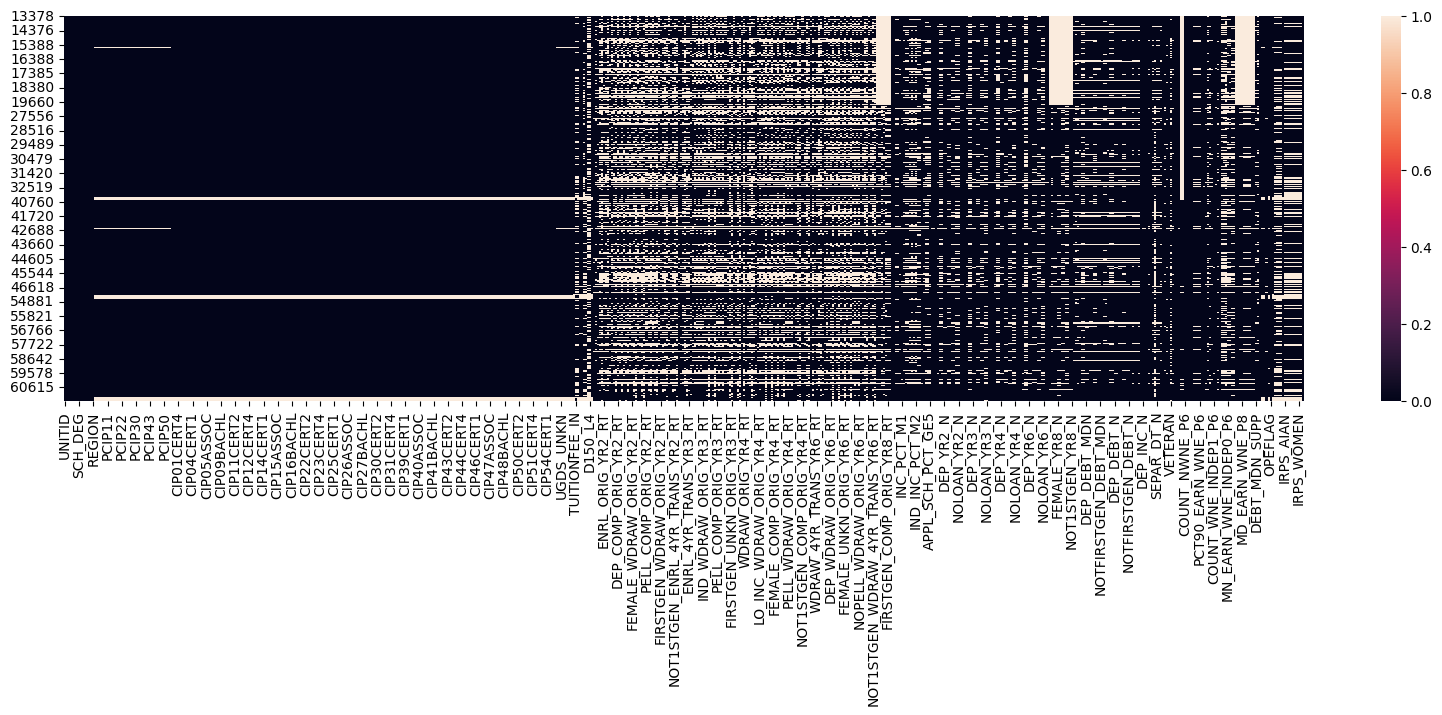

In [64]:
plt.figure(figsize=(20,5))
sns.heatmap(data.isnull())
plt.show()

In [46]:
data.PPTUG_EF.unique()

array([0.0587, 0.2425, 0.5014, ..., 0.355 , 0.5375, 0.6422])

In [ ]:
to_drop_cols = ["OPEID", "OPEID6", "INSTNM", "CITY", "ZIP", ""]
one_hot_cols = ["STABBR", "REGION"]
str_ordinal_cols = [""]
int_ordinal_cols = ["SCH_DEG", "PREDDEG","HIGHDEG","CONTROL"] #Categorical columns with inherent ordering
dummy_cols = ["UNITID", ""] #Categorical integers with high number of unique options
## CIP (Int Ordinal), PCIP (Percentage of CIP), 

In [ ]:
data.info(verbose=True)